In [1]:
from addit.ncf import conti
import jax.numpy as jnp
import numpy as np
from jax.lax import scan
from jax import jit, vmap
from addit.ncf import inc3D

In [2]:
N=10000
Ng_nu=40000
Ng_beta=5
Ng_gammaL=4

nus=np.linspace(1900.0,2300.0,Ng_nu) #nu grid
beta_grid=np.logspace(-2,1,Ng_beta) #beta grid
gammaL_grid=np.logspace(-2,1,Ng_gammaL)#gammaL grid
S=np.logspace(0.0,2.0,N)
S[0:10]=1000.0

nu_lines=np.random.rand(N)*(nus[-1]-nus[0]-100.0)+nus[0]+50.0
beta=np.random.rand(N)*1.0
gammaL=np.random.rand(N)*1.0

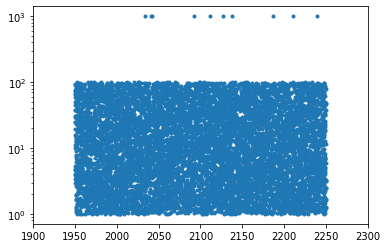

In [4]:
import matplotlib.pyplot as plt
plt.plot(nu_lines,S,".")
plt.xlim(nus[0],nus[-1])
plt.yscale("log")
plt.show()

In [5]:
def voigt_kernel(k, beta,gammaL):
    """Fourier Kernel of the Voigt Profile
    
    Args:
        k: conjugated of wavenumber
        beta: Gaussian standard deviation
        gammaL: Lorentian Half Width
        
    Returns:
        kernel (N_x,N_beta,N_gammaL)
    
    Note:
        Conversions to the (full) width, wG and wL are as follows: 
        wG=2*sqrt(2*ln2) beta
        wL=2*gamma
    
    """
    val=(jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]
    return jnp.exp(-2.0*val)
    

In [21]:
def rundit(S,nu_lines,beta,gammaL,nu_grid,beta_grid,gammaL_grid):
    """run DIT
    
    """
    Ng_nu=len(nu_grid)
    Ng_beta=len(beta_grid)
    Ng_gammaL=len(gammaL_grid)
    
    log_beta=jnp.log(beta)
    log_gammaL=jnp.log(gammaL)
    
    log_beta_grid = jnp.log(beta_grid)
    log_gammaL_grid = jnp.log(gammaL_grid)
    
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=inc3D(S,nu_lines,log_beta,log_gammaL,nu_grid,log_beta_grid,log_gammaL_grid)
    valbuf=jnp.vstack([val,jnp.zeros_like(val)])
    fftval = jnp.fft.rfft(valbuf,axis=0)
    fftvalsum = jnp.sum(fftval,axis=(1,2))
    vk=voigt_kernel(k, beta_grid,gammaL_grid)
    vkmean=jnp.mean(vk,axis=(1,2))
    #F0=jnp.fft.irfft(fftvalsum)[:Ng_nu]
    F0=jnp.fft.irfft(fftvalsum*vkmean)[:Ng_nu]
    return F0

In [22]:
F0=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

In [17]:
F0x=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

In [7]:
val=inc3D(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)
valbuf=jnp.vstack([val,jnp.zeros_like(val)])
print(jnp.shape(val),jnp.shape(valbuf))

(40000, 5, 4) (80000, 5, 4)


In [28]:
def check_norm(nu_grid,beta,gammaL):
    Ng_nu=len(nu_grid)
    dnu = (nu_grid[-1]-nu_grid[0])/(Ng_nu-1)
    k = jnp.fft.rfftfreq(2*Ng_nu,dnu)
    val=(jnp.pi*beta[None,:,None]*k[:,None,None])**2 + jnp.pi*gammaL[None,None,:]*k[:,None,None]
    return jnp.mean(val),jnp.min(val),jnp.max(val)

In [29]:
check_norm(nus, beta_grid,gammaL_grid)

(DeviceArray(170076.8, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(2468848.5, dtype=float32))

In [23]:
jnp.sum(F0)/jnp.sum(F0x)

DeviceArray(0.990519, dtype=float32)

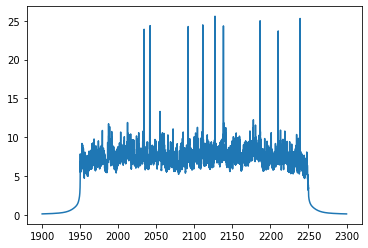

In [32]:
import matplotlib.pyplot as plt
#.plot(nus,F0x[:Ng_nu])
plt.plot(nus,F0)
#plt.yscale("log")
#plt.xlim(1960,1970)
plt.show()